In [1]:
import sys
sys.path.append("..") # this adds to path parent directory in order to import utils file
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import random
import numpy as np
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics.cluster import adjusted_rand_score
from statsmodels.base.model import GenericLikelihoodModel
from scipy import stats
import pickle
import pystan

import utils
import read_utils
np.random.seed(0)

elbowAnalysis
silhouetteAnalyis


In [2]:
%load_ext autoreload
%autoreload 2

## ZINBAWE model

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5773593/  
https://www.bioconductor.org/packages/devel/bioc/vignettes/zinbwave/inst/doc/intro.html   
https://github.com/drisso/zinb_analysis  
Reproduce comparaisons: https://github.com/fperraudeau/singlecellworkflow   


ZIFA:  
https://genomebiology.biomedcentral.com/articles/10.1186/s13059-015-0805-z  
https://github.com/epierson9/ZIFA  


PYSTAN:  
https://pystan.readthedocs.io/en/latest/index.html

In [18]:
stanCode = """

data {
  int<lower=0> N; // number of data points in dataset
  int<lower=1> P; // number of known covariates
  int<lower=1> K; // number of hidden dimensions
  int<lower=1> G; // number of observed genes
  int<lower=1> C; // number of observed cells

  vector[P] x[N]; // Covariates, including intercept.
  int y[N];      // Expression values (counts!)
  int<lower=1, upper=G> gene[N]; // Gene identifiers
  int<lower=1, upper=C> cell[N]; // Cell identifiers

}
parameters {
  // Latent variable model
  matrix[G, K] alpha_mu;
  matrix[G, K] alpha_pi;

  matrix[K, C] w;

  // Cell regression weights
  matrix[G, P] beta_mu;
  matrix[G, P] beta_pi;

  // Gene regression weights
  // (For now only do intercept)
  matrix[G, 1] gamma_mu;
  matrix[G, 1] gamma_pi;

  // Dispersion
  real zeta[G];

}
model {
  row_vector[1] mu;
  row_vector[1] pi_;
  real theta;

  // Priors
  to_vector(w) ~ normal(0, 1);

  // likelihood
  for (n in 1:N){
    mu = exp(beta_mu[gene[n]] * x[n] + gamma_mu[gene[N]] + alpha_mu[gene[n]] * col(w, cell[n]));
    pi_ = beta_pi[gene[n]] * x[n] + gamma_pi[gene[N]] + alpha_pi[gene[n]] * col(w, cell[n]);
    theta = exp(zeta[gene[n]]);

    if (y[n] > 0) {
      target += bernoulli_logit_lpmf(0 | pi_) + neg_binomial_2_lpmf(y[n] | mu, theta);
    }
    else {
      target += log_sum_exp(bernoulli_logit_lpmf(1 | pi_),
                            bernoulli_logit_lpmf(0 | pi_) + neg_binomial_2_lpmf(y[n] | mu, theta));
    }
  }
}

"""

In [19]:
%pastebin 18

'http://dpaste.com/295H852'

In [ ]:
model = pystan.StanModel(model_code=stanCode)

# Save compiled model

In [ ]:
with open('zinbwave.pkl', 'wb') as fh:
    pickle.dump(model, fh)

## Start here if the model was already generated

In [3]:
with open('zinbwave.pkl', 'rb') as fh:
    model = pickle.load(fh)

In [4]:
dataset= 'sce10x_qc'
df, truth = read_utils.loadData(dataset)
print(df.shape, truth.shape, truth.clusters.unique())

(902, 16468) (902, 2) [2 0 1]


In [5]:
# geneDf = df.T # log transform data
# geneDf['total_counts'] = geneDf.sum(axis = 1)
# geneDf['num_genes'] = (geneDf > 0).sum(axis = 1)
# geneDf['dispersion'] = (geneDf > 0).var(axis = 1) / (geneDf > 0).mean(axis = 1)
# geneDf = geneDf[['total_counts', 'num_genes', 'dispersion']]
# print(geneDf.shape)
# geneDf.head()

# geneDf['dispersion'].hist(log = False)
# plt.title('Histogram of gene dispersion')
# plt.xlabel('Dispersion value')
# plt.ylabel('Frequency');

## Keep only top 1000 genes with highest variation

TODO: remove also some cells 

In [6]:
geneDf = df.T # log transform data
geneDf.shape

(16468, 902)

In [7]:
idx = geneDf.pipe(np.log1p).var(1).sort_values(ascending=False).head(1000).index
mus = geneDf.pipe(np.log1p).mean(1)
vas = geneDf.pipe(np.log1p).var(1)
idx.shape, mus.shape, vas.shape

((1000,), (16468,), (16468,))

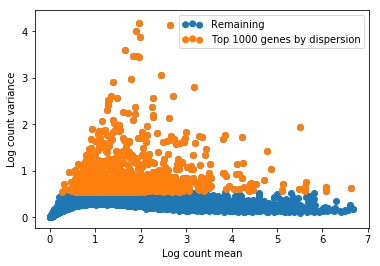

In [8]:
plt.scatter(mus, vas, label='Remaining');
plt.scatter(mus[idx], vas[idx], label=f'Top {idx.shape[0]} genes by dispersion');
plt.legend(scatterpoints=3)
plt.xlabel('Log count mean')
plt.ylabel('Log count variance');

In [9]:
cellNames = geneDf.columns.tolist()
cellNames[:3]

['CELL_000001', 'CELL_000002', 'CELL_000003']

In [10]:
geneDf = geneDf.loc[idx]
geneDf['gene'] = geneDf.index
print(geneDf.shape)
geneDf.head()

(1000, 903)


,CELL_000001,CELL_000002,CELL_000003,CELL_000004,CELL_000005,CELL_000006,CELL_000007,CELL_000008,CELL_000009,CELL_000010,...,CELL_000932,CELL_000933,CELL_000934,CELL_000935,CELL_000939,CELL_000943,CELL_000946,CELL_000955,CELL_000965,gene
ENSG00000108602,0,2,3,3,0,1,1,3,2,3,...,1,0,129,0,0,0,48,0,0,ENSG00000108602
ENSG00000019582,4,1,5,4,3,5,3,5,6,4,...,5,4,128,1,1,43,162,0,2,ENSG00000019582
ENSG00000173432,2,11,2,1,1,3,2,0,0,1,...,0,1,66,0,0,1,62,0,0,ENSG00000173432
ENSG00000148346,4,3,3,5,3,1,3,1,3,3,...,1,1,122,1,1,1,26,0,1,ENSG00000148346
ENSG00000196126,0,0,0,0,0,0,1,0,1,1,...,1,1,42,0,0,0,69,0,0,ENSG00000196126


In [11]:
long_data = pd.melt(geneDf, id_vars=['gene']).dropna().rename(columns={'variable': 'cell'})
print(long_data.shape)
long_data.head()

(902000, 3)


,gene,cell,value
0,ENSG00000108602,CELL_000001,0
1,ENSG00000019582,CELL_000001,4
2,ENSG00000173432,CELL_000001,2
3,ENSG00000148346,CELL_000001,4
4,ENSG00000196126,CELL_000001,0


In [12]:
genes = long_data.gene.astype('category')
G = genes.cat.categories.shape[0]
genes = genes.cat.codes.values + 1
len(genes), len(np.unique(genes)), genes[:3], G

(902000, 1000, array([216,  21, 724], dtype=int16), 1000)

In [13]:
cells = long_data.cell.astype('category')
C = cells.cat.categories.shape[0]
cells = cells.cat.codes.values + 1
len(cells), len(np.unique(cells)), cells[:3], C

(902000, 902, array([1, 1, 1], dtype=int16), 902)

In [14]:
y = long_data.value.values
y.shape

(902000,)

In [15]:
covars = np.zeros((len(y), 2))
covars[:, 0] = 1
covars.shape

(902000, 2)

In [16]:
N = y.shape[0]
P = covars.shape[1]
data = {
    'N': N, # number of observed values = #cells * #genes
    'P': P, # number of cell covariates
    'K': 2, # latent space size
    'G': G, # number of genes
    'C': C, # number of cells
    'x': covars, # cell covariates
    'y': y, # observed UMIs
    'gene': genes, # gene ids
    'cell': cells # cell ids
}

In [ ]:
o = model.optimizing(data=data)

C:\Users\ciort\Anaconda3\envs\stan_env\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [ ]:
W = o['w']

## Perform clustreing on W

In [ ]:
utils.elbowAnalysis(W, range(2, 5))

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
k=3
kmeanModel = KMeans(n_clusters=k)
kmeanModel.fit(W)

In [ ]:
pred = kmeanModel.predict(W)

In [ ]:
from sklearn.metrics.cluster import adjusted_rand_score
adjusted_rand_score(truth.clusters, pred)

In [ ]:
1